In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import h5py

from matplotlib.patches import Circle

### Loading data & ploting time signal image 

<HDF5 dataset "sigMat": shape (1500, 256, 1006), type "<f8">
float64
img converted to:  float32
img shape:  (256, 1006)
Max value of full image with DC offset removed: 20.196453094482422
min value of full image with DC offset removed: -19.805097579956055


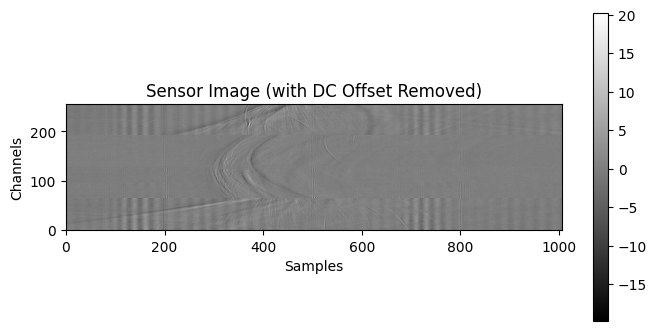

In [95]:
file = h5py.File('large_scale_testing/data_mat/sigMat_luis_leftarm_normal.mat','r')
print(file['sigMat'])
print(file['sigMat'].dtype)
# 1500 images, 256 channels, 1006 samples per channel
data = file.get('sigMat')

img_nb = 150
# limiting the channels because the side channels are showing something different
#ch_range = np.arange(65,193,1) # 130 channels kept out of 256

img = np.array(data[img_nb,:,:1006]) # crop until 1000 instead of 1006 full length

filtered = img - np.mean(img, axis=1, keepdims=True)

# # Normalize the image
# arr_min, arr_max = np.min(filtered), np.max(filtered)
# normed = (filtered - arr_min) / (arr_max - arr_min) #* 255

# normed = (normed - np.mean(normed)) / np.std(normed)  
normed = (filtered - np.mean(filtered)) / np.std(filtered)  

# Convert image to float32
normed = normed.astype(np.float32)
print('img converted to: ', normed.dtype)

print('img shape: ', filtered.shape)
plt.figure( figsize=(8, 4))
plt.imshow(normed, cmap='gray', origin='lower')
plt.title('Sensor Image (with DC Offset Removed)')
plt.xlabel('Samples')
plt.ylabel('Channels')
plt.colorbar()
print(f"Max value of full image with DC offset removed: {np.max(normed)}")
print(f"min value of full image with DC offset removed: {np.min(normed)}")

### Reconstruction function

In [53]:
def reconstruction(piezo_pos, timeSig, sos, T, nX, nY, xVec, yVec, max_dis):
    # output variable for the reconstruction
    recon = np.zeros((nY,nX))   

    time_points = np.arange(0, T*timeSig.shape[1], T) # pts with the time value foe each sample in timeSig

    for x in range(nX):
        for y in range(nY): 
        # for each pixel
            for ch in range(timeSig.shape[0]):
            #for each channel
                #ch = 100
                dis = np.sqrt((xVec[x] - piezo_pos[ch,0])**2 + (yVec[y] - piezo_pos[ch,1])**2)
                if dis < max_dis:
                    # print(f"dis: {dis} for x: {xVec[x]}, y: {yVec[y]}, ch: {ch}")
                    delay = dis / sos
                    # print(delay)
                    
                    # get index of closeset point for that delay
                    delay_point = int(round(delay / T))
                    if delay_point >= len(time_points):
                        continue
                    # print('delay_point: ', delay_point)

                    recon_temp = timeSig[ch, delay_point]
                    #print('recon_temp: ', recon_temp)

                    recon[y,x] += recon_temp
    return recon

### Defining Piezo Array Setup

In [ ]:
'''
defining pizo positions.

This cell fills the piezo_pos variable
'''
nb_channels = 256
piezo_pos = np.zeros((nb_channels,2)) 

### Linear segment
lin_pitch = 0.25e-3 # unit in meter
n_lin = 128
lin_receiver_pos = np.zeros((n_lin, 2))
for i in range(n_lin):
    lin_receiver_pos[i, 0] = i * lin_pitch
print('lin seg length: ', lin_receiver_pos[-1])

### Arc segment
pitch_conc = 0.6e-3 # m
n_arc = 64
r_conc = 38e-3 # m

# Calculate total angle covered by one arc:
arc_length = pitch_conc * (n_arc - 1)
arc_angle = arc_length / r_conc  # radians
theta_step = arc_angle / (n_arc - 1)
# print(arc_length, arc_angle * 180 / np.pi, 'degrees')

# create arc arrays
arc_pos_r = np.zeros((n_arc, 2))  # Right arc positions
arc_pos_l = np.zeros((n_arc, 2))  # Left arc positions

### Right arc: clockwise from theta_start
theta_start_r = np.pi / 2 - arc_angle - theta_step   # Start angle for right arc
for i in range(n_arc): # Right arc turning clockwise
    theta_i = theta_start_r + i * (theta_step) 
    # print(f"theta_i: {theta_i * 180 / np.pi} degrees")
    x = r_conc * np.cos(theta_i)
    y = r_conc * np.sin(theta_i)
    arc_pos_r[i, 0] = x
    arc_pos_r[i, 1] = y

# Shift right arc to start at the end of linear segment
x_shift = lin_receiver_pos[-1, 0] 
arc_pos_r[:, 0] += x_shift
# Shift down the arc
y_shift = - r_conc  
arc_pos_r[:, 1] += y_shift

### Left arc: counterclockwise from theta_center_left (centered at negative x)
theta_start_l = np.pi / 2 + theta_step # extra step to it doesn't overlap with linear segment

for i in range(n_arc): # Right arc turning clockwise
    theta_i = theta_start_l + i * (theta_step) 
    # print(f"theta_i: {theta_i * 180 / np.pi} degrees")
    x = r_conc * np.cos(theta_i)
    y = r_conc * np.sin(theta_i)
    arc_pos_l[i, 0] = x
    arc_pos_l[i, 1] = y

# Shift down the arc
arc_pos_l[:, 1] += y_shift

# circle = Circle((0, 0), r_conc, color='b', fill=False, linewidth=1.5, label=f'Arc radius {r_conc*1e3:.1f} mm')

# Fill piezo_pos array
piezo_pos[:n_arc] = arc_pos_l
piezo_pos[n_arc:n_arc+n_lin] = lin_receiver_pos
piezo_pos[n_arc+n_lin:] = arc_pos_r

fig, ax = plt.subplots(figsize=(12, 4))
# ax.scatter(lin_receiver_pos[:, 0], lin_receiver_pos[:, 1], marker='.', color='blue')
# ax.scatter(arc_pos_r[:, 0], arc_pos_r[:, 1], marker='.', color='red', label='Right Arc')
# ax.scatter(arc_pos_l[:, 0], arc_pos_l[:, 1], marker='.', color='green', label='Left Arc')
ax.scatter(piezo_pos[:, 0], piezo_pos[:, 1], marker='.', color='black', label='Piezo Positions')
# ax.add_patch(circle)
ax.axis('equal')
plt.grid()
plt.show()

dict_keys(['__header__', '__version__', '__globals__', 'x_sensor', 'y_sensor'])


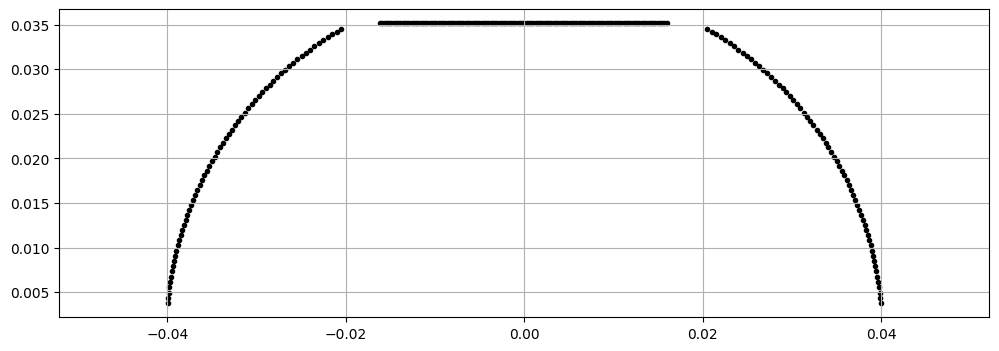

In [96]:
import scipy.io

nb_channels = 256
piezo_pos = np.zeros((nb_channels,2)) 

sensor_pos = scipy.io.loadmat('dataset5/pos_sensors_multisegment.mat')
print(sensor_pos.keys())

x_pos = sensor_pos['x_sensor'].flatten()
y_pos = sensor_pos['y_sensor'].flatten()

piezo_pos = np.column_stack((x_pos, y_pos))

fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(piezo_pos[:, 0], piezo_pos[:, 1], marker='.', color='black', label='Piezo Positions')
# ax.add_patch(circle)
ax.axis('equal')
plt.grid()
plt.show()

### Defining FOV & other parameters

nb time pts:  1006
max time:  2.5149999999999998e-05  s
max distance:  37.976499999999994  mm
lin seg length:  0.032131 m
FOV:  [0.032131 0.032131]  m
nX, nY:  128 128


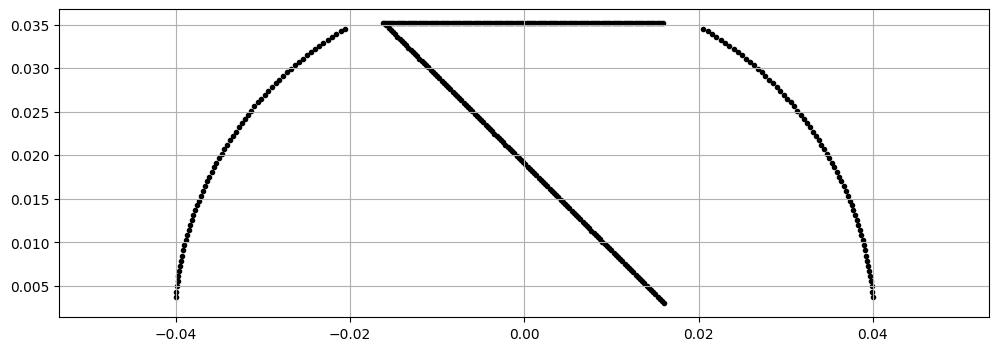

In [84]:
### Defining time points ###
############################
# Sampling rate
nb_time_pts = 1006 # number of time points
print("nb time pts: ", nb_time_pts)
sample_rate = 40 * 10**6  # 40 MHz
T = 1 / sample_rate  # in seconds
time_points = np.arange(0, T*nb_time_pts, T) # 1006 pts with the time value from the sampling freq

### Definging FOV ###
#####################
sos = 1510;  # unit m/s
max_time = nb_time_pts * T  
print("max time: ", max_time, " s")
max_dis = T * nb_time_pts * sos
print("max distance: ", max_dis * 1e3, " mm")

# the linear segment is 31.75 mm long. this will be taken as FOV square side length
lin_seg_length = piezo_pos[191, 0] - piezo_pos[64, 0]
print('lin seg length: ', lin_seg_length, 'm')
FOV = np.array([lin_seg_length , lin_seg_length ]) # unit in meter
print("FOV: ", FOV, " m")

# Resolution from the paper (based on receiver BW central frequency)
resolution = np.array([250, 250]) * 10**-6 # unit in m

# nb points for each axis 
nX = int(FOV[0] / resolution[0]) #+ 1 
nY = int(FOV[1] / resolution[1]) #+ 1
print("nX, nY: ", nX, nY)

# coordinates of the FOV grid wrt the array coordinate system
xVec = np.linspace(-FOV[0]/2,FOV[0]/2,nX) 
# y_begin = 0 - 34e-3 + lin_seg_length / 2
# y_end = y_begin - FOV[1]
yVec = np.linspace(piezo_pos[64, 1],piezo_pos[64, 1]-FOV[1],nY)

fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(xVec, yVec, marker='.', color='black', label='FOV Grid Points')
ax.scatter(piezo_pos[:, 0], piezo_pos[:, 1], marker='.', color='black', label='Piezo Positions')
ax.axis('equal')
plt.grid()
plt.show()

### Reconstructing one image

shape timeSig:  (256, 1006)
Max value of reconstruction: 123.02267841342837
Min value of reconstruction: -67.72346738248598
Max value of reconstruction: 5.262501244886019
Min value of reconstruction: -4.322584873513913
reconstruction shape: (128, 128)


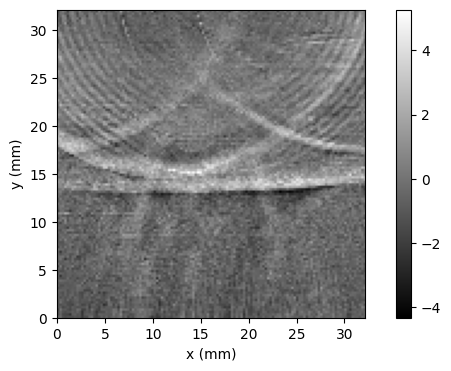

In [100]:
file = h5py.File('large_scale_testing/data_mat/sigMat_luis_rightarm_normal.mat','r')
data = file.get('sigMat')

img_nb = 1350
timeSig = np.array(data[img_nb,:,:]) # 100th frame: 256 channels, 1006 tisignal value samples
filtered = timeSig - np.mean(timeSig, axis=1, keepdims=True) # remove DC offset
# normalizing to 0-1
# arr_min, arr_max = np.min(filtered), np.max(filtered)
# normed = (filtered - arr_min) / (arr_max - arr_min) 
normed = (filtered - np.mean(filtered)) / np.std(filtered)  

# Convert image to float32
normed = normed.astype(np.float32)

print('shape timeSig: ', np.shape(normed))

recon = reconstruction(piezo_pos, normed, sos, T, nX, nY, xVec, yVec, max_dis)

# arr_min, arr_max = np.min(recon), np.max(recon)
# recon = (recon - arr_min) / (arr_max - arr_min) * 255

print(f"Max value of reconstruction: {np.max(recon)}")
print(f"Min value of reconstruction: {np.min(recon)}")

recon = (recon - np.mean(recon)) / np.std(recon)  

print(f"Max value of reconstruction: {np.max(recon)}")
print(f"Min value of reconstruction: {np.min(recon)}")

plt.figure( figsize=(8, 4))
plt.imshow(recon, cmap='gray', origin='lower',
           extent=(0, FOV[0]*10**3, 0, FOV[1]*10**3))
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.colorbar()

print(f'reconstruction shape: {recon.shape}')

# Generating dataset 5

### Generate input

In [105]:
# create directories for saving the dataset
os.makedirs('dataset5/training/input', exist_ok=True)  
os.makedirs('dataset5/testing/input', exist_ok=True)  

def get_img(img_nb, data):
    """
    Get the image at index img_nb from the data array.
    Apply preprocessing setps:
    1. Remove DC offset
    2. Normalization
    3. Convert to float32
    4. Median padding (to ensure the image is in the correct format)
    """
    out_shape = ([256, 1024])
    #original_shape = ([256,1006])

    img = np.array(data[img_nb,:,:])  # Extract the image
    filtered = img - np.mean(img, axis=1, keepdims=True) # Remove DC offset
    normed = (filtered - np.mean(filtered)) / np.std(filtered) # Normalize the image
    normed = normed.astype(np.float32) # Convert image to float32
    out = np.zeros([256,1024], dtype=np.float32) 
    out[:,0:1006] = normed
    out[:,1006:] = np.median(normed, axis=1)[:, np.newaxis] # median padding

    return out 


dir = 'large_scale_testing/data_mat/'
i = 0
for filename in os.listdir(dir):
    # file 0: sigMat_luis_leftarm_parallel.mat
    # file 1: sigMat_luis_leftarm_normal.mat
    # file 2: sigMat_luis_rightarm_normal.mat
    # file 3: sigMat_luis_rightarm_parallel.mat
    if filename.endswith('.mat'):
        print(f"Processing file: {filename}")
        # Load the .mat file
        filepath = os.path.join(dir, filename)
        file = h5py.File(filepath,'r')
        # 1500 images, 256 channels, 1006 samples per channel: (1500, 256, 1006)
        data = file.get('sigMat')
        data = data[100:, :, :]
        print(data.shape) # the first 100 images bad

        # data array [N_samples, C, H, W] = [N_images, 1, 256 channels, 1024 samples] (good shape for Unet)
        input = np.zeros((data.shape[0]-1, 1, data.shape[1], 1024), dtype=np.float32) 

        for img_nb in range(data.shape[0]-1):
            img = get_img(img_nb, data)
            input[img_nb, 0, :, :] = img

        # devide training and testing data
        N = input.shape[0]
        test_size = int(0.1 * N)  # 10% for testing
        # Randomly select unique indices for testing
        test_indices = np.random.choice(N, size=test_size, replace=False)
        # Create boolean mask for test/train split
        mask = np.zeros(N, dtype=bool)
        mask[test_indices] = True
        # Split the dataset
        test_input = input[mask]
        train_input = input[~mask]
        print(test_input.shape, train_input.shape)

        # Save arrays 
        np.save(f'dataset5/testing/input/test_input_{i}.npy', test_input)
        np.save(f'dataset5/training/input/train_input_{i}.npy', train_input)

        i += 1


Processing file: sigMat_luis_leftarm_parallel.mat
(1400, 256, 1006)
(139, 1, 256, 1024) (1260, 1, 256, 1024)
Processing file: sigMat_luis_leftarm_normal.mat
(1400, 256, 1006)
(139, 1, 256, 1024) (1260, 1, 256, 1024)
Processing file: sigMat_luis_rightarm_normal.mat
(1400, 256, 1006)
(139, 1, 256, 1024) (1260, 1, 256, 1024)
Processing file: sigMat_luis_rightarm_parallel.mat
(1400, 256, 1006)
(139, 1, 256, 1024) (1260, 1, 256, 1024)


Shape of the image: (256, 1024)
image type: float32


Text(0, 0.5, 'Channels')

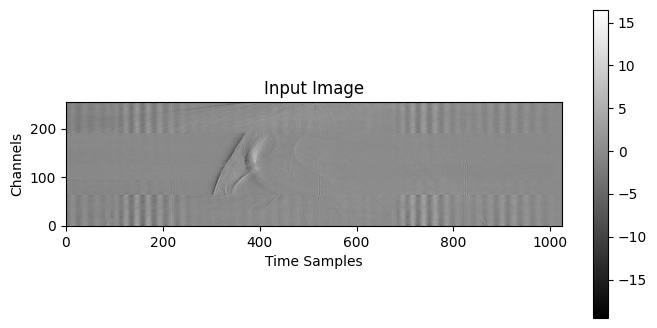

In [7]:
file_path = 'dataset5/all_test/input/test_input_all.npy'
data = np.load(file_path)

img = data[11, 0, :, :]  # Access the first image in the batch
print(f"Shape of the image: {img.shape}")
print(f'image type: {img.dtype}')
plt.figure( figsize=(8, 4))
plt.imshow(img, cmap='gray', origin='lower')
# plt.title('Full Image with DC Offset Removed')
plt.title('Input Image')
plt.colorbar()
plt.xlabel('Time Samples')
plt.ylabel('Channels')

### Generate output

In [113]:
os.makedirs('dataset5/training/output', exist_ok=True)  
os.makedirs('dataset5/testing/output', exist_ok=True)  

# generate training output
dir_train = 'dataset5/training/input/'
for file in os.listdir(dir_train):
    if file.endswith('.npy'): # and file[12]== '1': # only dataset 1 for speed !!!
        print(f"Processing file: {file}")
        i = file[12]
        input_data = np.load(os.path.join(dir_train, file))

        # output array [N_samples, C, H, W]
        label = np.zeros((input_data.shape[0], 1, nY, nX), dtype=np.float32)

        # input_data shape: (N_samples, 1, 256, 1024)
        for img_nb in range(input_data.shape[0]):
            timeSig = input_data[img_nb, 0, :, :1006]  # Take out the median padding for standard reconstruction !!
            recon = reconstruction(piezo_pos, timeSig, sos, T, nX, nY, xVec, yVec, max_dis)
            # Normalize output
            recon = (recon - np.mean(recon)) / np.std(recon) 
            # Save the reconstruction
            label[img_nb, 0, :, :] = recon
        
        np.save(f'dataset5/training/output/train_label_{i}.npy', label)
        

# generate testing output
dir_test = 'dataset5/testing/input/'
for file in os.listdir(dir_test):
    if file.endswith('.npy'): # and file[11]== '1': # only dataset 1 for speed !!!
        print(f"Processing file: {file}")
        i = file[11]
        input_data = np.load(os.path.join(dir_test, file))

        # output array [N_samples, C, H, W]
        label = np.zeros((input_data.shape[0], 1, nY, nX), dtype=np.float32)

        # input_data shape: (N_samples, 1, 130, 1006)
        for img_nb in range(input_data.shape[0]):
            timeSig = input_data[img_nb, 0, :, :1006]  # Get the time signal for the image
            recon = reconstruction(piezo_pos, timeSig, sos, T, nX, nY, xVec, yVec, max_dis)
            # Normalize output
            recon = (recon - np.mean(recon)) / np.std(recon) 
            # Save the reconstruction
            label[img_nb, 0, :, :] = recon
        
        np.save(f'dataset5/testing/output/test_label_{i}.npy', label)
        

Processing file: train_input_2.npy
Processing file: train_input_1.npy
Processing file: train_input_3.npy
Processing file: train_input_0.npy
Processing file: test_input_1.npy
Processing file: test_input_3.npy
Processing file: test_input_0.npy
Processing file: test_input_2.npy


(556, 1, 128, 128)


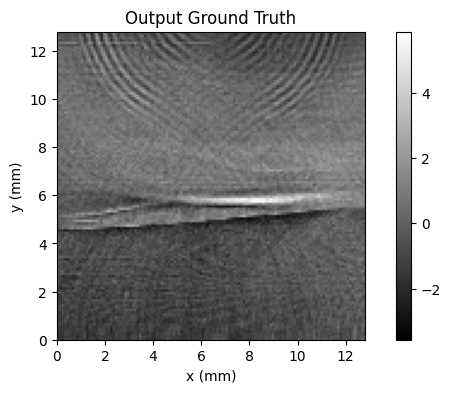

In [9]:
# Check image generated properly
# file_path = 'dataset5/all_train/output/train_label_all.npy'
file_path = 'dataset5/all_test/output/test_label_all.npy'

# Load the array from the .npy file
data = np.load(file_path)
print(data.shape)
recon = data[11, 0, :, :]  # Access the first image in the batch
# arr_min, arr_max = np.min(recon), np.max(recon)
# recon = (recon - arr_min) / (arr_max - arr_min) #* 255
recon = (recon - np.mean(recon)) / np.std(recon) # Normalize the image

# Rotate 180 degrees
recon_inverted = np.rot90(recon, 2)

plt.figure( figsize=(8, 4))
plt.imshow(recon, cmap='gray', origin='lower',
           extent=(0, recon.shape[0]*10**-1, 0, recon.shape[1]*10**-1))
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('Output Ground Truth')
plt.colorbar()

### Combine 4 datasets together

In [123]:
os.makedirs('dataset5/all_train/input', exist_ok=True)  
os.makedirs('dataset5/all_train/output', exist_ok=True)  
os.makedirs('dataset5/all_test/input', exist_ok=True)  
os.makedirs('dataset5/all_test/output', exist_ok=True)  

### Concatinate training input files
# List your files in loading order
file_list = ['train_input_0.npy', 'train_input_1.npy', 'train_input_2.npy', 'train_input_3.npy']
paths_train_input = [os.path.join('dataset5/training/input/', f) for f in file_list]
# Load all arrays into a list
arrays = [np.load(f) for f in paths_train_input]
# Concatenate along the first axis (axis=0)
combined_array = np.concatenate(arrays, axis=0)

np.save(f'dataset5/all_train/input/train_input_all.npy', combined_array)

### Concatinate training output files
file_list = ['train_label_0.npy', 'train_label_1.npy', 'train_label_2.npy', 'train_label_3.npy']
paths_train_output = [os.path.join('dataset5/training/output/', f) for f in file_list]
arrays = [np.load(f) for f in paths_train_output]
combined_array = np.concatenate(arrays, axis=0)
np.save(f'dataset5/all_train/output/train_label_all.npy', combined_array)

### Concatinate testing input files
file_list = ['test_input_0.npy', 'test_input_1.npy', 'test_input_2.npy', 'test_input_3.npy']
paths_test_input = [os.path.join('dataset5/testing/input/', f) for f in file_list]
arrays = [np.load(f) for f in paths_test_input]
combined_array = np.concatenate(arrays, axis=0)
print("Combined array shape for testing input:", combined_array.shape)
np.save(f'dataset5/all_test/input/test_input_all.npy', combined_array)
print('done')  

### Concatinate testing output files
file_list = ['test_label_0.npy', 'test_label_1.npy', 'test_label_2.npy', 'test_label_3.npy']
paths_test_output = [os.path.join('dataset5/testing/output/', f) for f in file_list]
arrays = [np.load(f) for f in paths_test_output]
combined_array = np.concatenate(arrays, axis=0)
np.save(f'dataset5/all_test/output/test_label_all.npy', combined_array) 

Combined array shape for testing input: (556, 1, 256, 1024)
done


### Generate dataset with only 128 linear segment channels

In [128]:
os.makedirs('dataset5/all_train/input_128', exist_ok=True)  
os.makedirs('dataset5/all_test/input_128', exist_ok=True)  

file_dir = 'dataset5/all_train/input'
for file in os.listdir(file_dir):
    if file.endswith('.npy'): 
        print(f"Processing file: {file}")
        input_data = np.load(os.path.join(file_dir, file))

        print(input_data.shape)
        cropped_input = input_data[:, :, 64:192, :]
        print(cropped_input.shape)
        np.save(f'dataset5/all_train/input_128/train_input_all.npy', cropped_input)

# crop test_all/input
file_dir = 'dataset5/all_test/input'
for file in os.listdir(file_dir):
    if file.endswith('.npy'): 
        print(f"Processing file: {file}")
        input_data = np.load(os.path.join(file_dir, file))

        print(input_data.shape)
        cropped_input = input_data[:, :, 64:192, :]

        np.save(f'dataset5/all_test/input_128/test_input_all.npy', cropped_input)


Processing file: train_input_all.npy
(5040, 1, 256, 1024)
(5040, 1, 128, 1024)
Processing file: test_input_all.npy
(556, 1, 256, 1024)
